# Desafío 02

## Integrantes

- Acevedo Zain, Gaspar (acevedo.zain.gaspar@gmail.com)

## Consignas

**Cada experimento realizado debe estar acompañado de una explicación o interpretación de lo observado**

Recuerden que su notebook de entrega debe poder correrse de inicio a fin sin la aparición de errores.

- Crear sus propios vectores con Gensim basado en lo visto en clase con otro artista del dataset Songs.
- Elegir términos de interés y buscar términos más similares y menos similares.
- Realizar una reduccion de dimensionalidad a los embeddings, llevándolos a 2 dimensiones. Graficar los embeddings proyectados y seleccionar una cantidad de términos (variable MAX_WORDS) de forma tal que la visualización sea adecuada.
- Inspeccionar el grafico y buscar pequeños grupos de palabras que puedan formarse. Interpretarlos e intentar obtener conclusiones. En lo posible, acompañar los grupos de palabras con capturas (y pegarlas en celdas de texto)

## Imports

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
import platform

from gensim.models.callbacks import CallbackAny2Vec

In [2]:
import multiprocessing
try:
  from gensim.models import Word2Vec
except:
  !pip install gensim
  from gensim.models import Word2Vec

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 65.0 MB/s eta 0:00:00


In [3]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string

In [4]:
nltk.download("punkt")
nltk.download('punkt_tab')
nltk.download("wordnet")
nltk.download('stopwords')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

## Descarga del dataset

Se descarga el dataset provisto por el postgrado:

In [5]:
if os.access('./songs_dataset', os.F_OK) is False:
    if os.access('songs_dataset.zip', os.F_OK) is False:
        if platform.system() == 'Windows':
            !curl https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/datasets/songs_dataset.zip -o songs_dataset.zip
        else:
            !wget songs_dataset.zip https://github.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/raw/main/datasets/songs_dataset.zip
    !unzip -q songs_dataset.zip
else:
    print("El dataset ya se encuentra descargado")

--2025-11-11 01:07:20--  http://songs_dataset.zip/
Resolving songs_dataset.zip (songs_dataset.zip)... failed: Name or service not known.
wget: unable to resolve host address ‘songs_dataset.zip’
--2025-11-11 01:07:20--  https://github.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/raw/main/datasets/songs_dataset.zip
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/datasets/songs_dataset.zip [following]
--2025-11-11 01:07:20--  https://raw.githubusercontent.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/main/datasets/songs_dataset.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.

## Creación del dataset

A partir de los datos descargados, se crea un dataframe con las canciones de *bob-dylan* de la siguiente manera:

In [79]:
df = pd.read_csv('songs_dataset/bob-dylan.txt', sep='/n', header=None)

/tmp/ipython-input-2133178393.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv('songs_dataset/bob-dylan.txt', sep='/n', header=None)


El dataframe creado tiene un total de $5213$ documentos:

In [80]:
print(f"Cantidad de documentos: {df.shape[0]}")

Cantidad de documentos: 5213


## 1) Creación de Vectores

- Crear sus propios vectores con Gensim basado en lo visto en clase con otro artista del dataset Songs.

### Preprocesamiento

Comenzamos definiendo la función `nltk_process` (fuente: [Notebook de preprocesamiento](https://github.com/gasper-az/procesamiento_lenguaje_natural/blob/main/clase_2/jupyter_notebooks/2a%20-%20preprocesamiento.ipynb) de la clase 2) la cual realiza el preprocesamiento de distintos textos mediante la library de [NLTK](https://www.nltk.org/).



Esta función realiza las siguientes operaciones sobre un texto dado:

1. Tokenización: mediante la función [word_tokenize](https://www.nltk.org/api/nltk.tokenize.html#nltk.tokenize.word_tokenize) se separa el texto de entrada en una lista de ***tokens***.
1. Lematización: se implementa mediante [WordNetLemmatizer](https://www.nltk.org/api/nltk.stem.WordNetLemmatizer.html). En este paso también se reemplaza el caracter `’` por `'`, a fin de que se procesen correctamente ciertos términos como `let's` o `it's`.
1. Stop words: se filtran las stop words, es decir, los términos que aportan poco valor de información al texto, en este caso del idioma inglés.
1. Filtro de caracteres de puntuación: finalmente, se filtran los caracters de puntuación. En este caso también se agregan los caracteres de `“` y `”`, ya que aparecen en el corpus, y no queremos que los trate como términos.

In [100]:
def nltk_process(text):
    # Tokenization
    nltk_tokenList = word_tokenize(text)

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    nltk_lemmaList = []
    for word in nltk_tokenList:
      replaced_word = word.replace("’", "'")
      nltk_lemmaList.append(lemmatizer.lemmatize(replaced_word))

    # Stop words
    nltk_stop_words = set(stopwords.words("english"))

    filtered_sentence = [w for w in nltk_lemmaList if w not in nltk_stop_words]

    # Filter Punctuation
    str_punctuaction = string.punctuation + "“”"
    filtered_sentence = [w for w in filtered_sentence if w not in str_punctuaction]

    return filtered_sentence

Luego, por cada documento del corpus, lo que serían partes de las letras de las canciones de Bob Dylan, se llama a la función `nltk_process`, para así ir obteniendo los distintos tokens de la misma.

Estos tokens son almacenados en la lista `sentence_tokens`.

In [101]:
sentence_tokens = []

for _, row in df[:None].iterrows():
    sentence_tokens.append(nltk_process(row[0]))

### Creación de vectores (word2vec)

El siguiente código está basado en la notebook [Custom Embedding con Gensim](https://github.com/gasper-az/procesamiento_lenguaje_natural/blob/main/clase_2/jupyter_notebooks/2c%20-%20Custom%20embedding%20con%20Gensim.ipynb) de la clase 2 de la materia.

A fin de crear nuestros embeddings, comenzamos creando un modelo `Word2Vec`, el cual nos permitirá capturar relaciones semánticas entre palabras al entrenar una red neuronal, basada en el corpus preprocesado en el paso anterior.

Nuestro modelo tiene los siguientes hiperparámetros:
- [min_count](https://radimrehurek.com/gensim/auto_examples/tutorials/run_word2vec.html#min-count): indica la cantidad mínima de veces que debe aparecer un término para ser utilizado en los vectores. Utilizamos el valor $5$.
- window: cantidad de términos alrededor del término analizado que serán considerados para crear el vector. Utilizamos el valor $2$.
- [vector_size](https://radimrehurek.com/gensim/auto_examples/tutorials/run_word2vec.html#vector-size): número de dimensiones que tendrá el vector final. Utilizamos el valor $300$.
- `workers`: indica si se paralelizará el entrenamiento o no según la cantidad indicada. En este caso utilizamos $1$, es decir, sin paralelización.
- `sg`: infica si se utiliza `Skip-grams` o `Continuous Bag of Words`. En este caso, utilizamos `Skip-grams`.

In [102]:
class callback(CallbackAny2Vec):
    """
    Callback to print loss after each epoch
    """
    def __init__(self):
        self.epoch = 0

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        if self.epoch == 0:
            print('Loss after epoch {}: {}'.format(self.epoch, loss))
        else:
            print('Loss after epoch {}: {}'.format(self.epoch, loss- self.loss_previous_step))
        self.epoch += 1
        self.loss_previous_step = loss

In [103]:
w2v_model = Word2Vec(min_count=5,
                     window=2,
                     vector_size=300,
                     negative=20,
                     workers=1,
                     sg=1)

In [104]:
w2v_model.build_vocab(sentence_tokens)

In [105]:
print("Cantidad de docs en el corpus:", w2v_model.corpus_count)

Cantidad de docs en el corpus: 5213


In [106]:
print("Cantidad de términos distintas en el corpus:", len(w2v_model.wv.index_to_key))

Cantidad de términos distintas en el corpus: 883


### Entrenamiento de embeddings

Finalmente, mediante el método `train` entrenamos el modelo.

En este caso, utilizamos $50$ épocas.

In [107]:
w2v_model.train(sentence_tokens,
                total_examples=w2v_model.corpus_count,
                epochs=50,
                compute_loss = True,
                callbacks=[callback()]
                )

Loss after epoch 0: 223243.5625
Loss after epoch 1: 100174.25
Loss after epoch 2: 97566.5625
Loss after epoch 3: 97843.21875
Loss after epoch 4: 100528.46875
Loss after epoch 5: 99104.5625
Loss after epoch 6: 99112.5
Loss after epoch 7: 97131.25
Loss after epoch 8: 96191.9375
Loss after epoch 9: 86690.8125
Loss after epoch 10: 79989.25
Loss after epoch 11: 78476.5
Loss after epoch 12: 76332.75
Loss after epoch 13: 74678.0
Loss after epoch 14: 72261.875
Loss after epoch 15: 70894.5
Loss after epoch 16: 69277.0
Loss after epoch 17: 68646.125
Loss after epoch 18: 65610.125
Loss after epoch 19: 65090.625
Loss after epoch 20: 63548.875
Loss after epoch 21: 61841.75
Loss after epoch 22: 61392.375
Loss after epoch 23: 59990.875
Loss after epoch 24: 56477.0
Loss after epoch 25: 52420.25
Loss after epoch 26: 52233.0
Loss after epoch 27: 51352.5
Loss after epoch 28: 50299.75
Loss after epoch 29: 49729.0
Loss after epoch 30: 48862.75
Loss after epoch 31: 49166.0
Loss after epoch 32: 48234.25
Loss

(720152, 1180450)

## 2) Términos similares

- Elegir términos de interés y buscar términos más similares y menos similares.

Estos son los $5$ términos de interés que se analizarán en esta sección:
- Stone
- church
- heaven
- people
- angel

### 2.1) Términos más y menos similares a `Stone`

En este caso destacamos los términos `unknown` (con similaridad de $0.6358$), `rolling` (con similaridad de $0.6281$) que aparecen en la canción ***Like a rolling `stone`***, de ahí a que tengan similitud con el término de estudio.

In [118]:
w2v_model.wv.most_similar(positive=["stone"], topn=10)

[('ground', 0.7641337513923645),
 ('ya', 0.7212523818016052),
 ('shadow', 0.682569682598114),
 ('walking', 0.663827657699585),
 ('floor', 0.6546837687492371),
 ('unknown', 0.6358175873756409),
 ('rolling', 0.6280930638313293),
 ('Thunder', 0.6266703009605408),
 ('cast', 0.6264036893844604),
 ('Blind', 0.624392569065094)]

In [109]:
w2v_model.wv.most_similar(negative=["stone"], topn=10)

[('Saved', -0.008977290242910385),
 ('This', -0.07446137815713882),
 ('hear', -0.08113624900579453),
 ('take', -0.08271683007478714),
 ('tongue', -0.09840873628854752),
 ('No', -0.10374912619590759),
 ('My', -0.10532881319522858),
 ('place', -0.11019222438335419),
 ('another', -0.12061450630426407),
 ('A', -0.12729200720787048)]

### 2.2) Términos más y menos similares a `church`

In [120]:
w2v_model.wv.most_similar(positive=["church"], topn=10)

[('Brown', 0.8489817976951599),
 ('house', 0.7676243782043457),
 ('nerve', 0.7092726230621338),
 ('cast', 0.7088154554367065),
 ('Zanzinger', 0.7007275223731995),
 ('Lenny', 0.6993017792701721),
 ('dry', 0.6916943192481995),
 ('William', 0.6881160736083984),
 ('Thunder', 0.6845272779464722),
 ('lived', 0.6747941374778748)]

In [111]:
w2v_model.wv.most_similar(negative=["church"], topn=10)

[('hear', -0.08370925486087799),
 ('mind', -0.09618458896875381),
 ('Saved', -0.11617130786180496),
 ('even', -0.13622935116291046),
 ('low', -0.14310064911842346),
 ('doe', -0.14459063112735748),
 ('change', -0.14858722686767578),
 ('away', -0.17006158828735352),
 ('Sometimes', -0.17601466178894043),
 ('better', -0.17605261504650116)]

### 2.3) Términos más y menos similares a `heaven`

Se observa que los términos `Knock` (con *k* mayúscula), `knockin` y `knock` (con *k* minúscula) son los que mayor similitud tienen con `heaven`. Esto puede deberse a la canción `Knockin' On Heaven's Door`.

In [119]:
w2v_model.wv.most_similar(positive=["heaven"], topn=10)

[('Knock', 0.8999813795089722),
 ('knockin', 0.8765838146209717),
 ('knock', 0.8589088916778564),
 ('Throw', 0.7828720211982727),
 ('close', 0.7541313767433167),
 ('Someone', 0.7329607009887695),
 ('kiss', 0.7076137065887451),
 ('Me', 0.7053238749504089),
 ('Standing', 0.6622973680496216),
 ('trouble', 0.6600295305252075)]

In [113]:
w2v_model.wv.most_similar(negative=["heaven"], topn=10)

[('Saved', -0.03856530785560608),
 ('come', -0.11427926272153854),
 ('Then', -0.11791307479143143),
 ('bad', -0.1351763904094696),
 ('And', -0.15868817269802094),
 ('remember', -0.16137832403182983),
 ('rain', -0.16730545461177826),
 ('place', -0.17418253421783447),
 ('tell', -0.1747073531150818),
 ('best', -0.17825032770633698)]

### 2.4) Términos más y menos similares a `people`

In [114]:
w2v_model.wv.most_similar(positive=["people"], topn=10)

[('breeze', 0.5727124810218811),
 ('seven', 0.5628980398178101),
 ('reason', 0.5509018898010254),
 ('death', 0.5313238501548767),
 ('stuff', 0.5147362351417542),
 ('Into', 0.513581395149231),
 ('sometimes', 0.5100373029708862),
 ('n', 0.5078936815261841),
 ('round', 0.49984464049339294),
 ('poison', 0.4954186975955963)]

In [115]:
w2v_model.wv.most_similar(negative=["people"], topn=10)

[('Saved', 0.03366702049970627),
 ('My', -0.022308502346277237),
 ('hide', -0.0703115463256836),
 ('love', -0.07260383665561676),
 ('every', -0.07489440590143204),
 ('til', -0.08638288825750351),
 ('stand', -0.0937083512544632),
 ('world', -0.09458473324775696),
 ('tell', -0.0954766795039177),
 ('It', -0.09901346266269684)]

### 2.5) Términos más y menos similares a `angel`

In [116]:
w2v_model.wv.most_similar(positive=["angel"], topn=10)

[('Ai', 0.7724217176437378),
 ('bottom', 0.7351744771003723),
 ('neither', 0.7304282188415527),
 ('forgives', 0.7203497290611267),
 ('dime', 0.7182389497756958),
 ('younger', 0.6974844336509705),
 ('ai', 0.6890485286712646),
 ('honor', 0.6881652474403381),
 ('guess', 0.6838685870170593),
 ('nature', 0.6765079498291016)]

In [117]:
w2v_model.wv.most_similar(negative=["angel"], topn=10)

[('Saved', -0.0035482493694871664),
 ('heart', -0.15954738855361938),
 ('There', -0.21530912816524506),
 ('To', -0.21891143918037415),
 ('get', -0.2243724763393402),
 ('hand', -0.2362736016511917),
 ('way', -0.23708659410476685),
 ('face', -0.23977360129356384),
 ('He', -0.2404944747686386),
 ('walk', -0.24255087971687317)]

## 3) Reducción de dimensionalidad

- Realizar una reduccion de dimensionalidad a los embeddings, llevándolos a 2 dimensiones. Graficar los embeddings proyectados y seleccionar una cantidad de términos (variable MAX_WORDS) de forma tal que la visualización sea adecuada.

Se implementa en esta sección la técnica de `T-SNE` mediante la cual podemos visualizar la dimensionalidad de los embeddings en $2$ dimensiones.

In [121]:
from sklearn.decomposition import IncrementalPCA
from sklearn.manifold import TSNE
import numpy as np

def reduce_dimensions(model, num_dimensions = 2 ):

    vectors = np.asarray(model.wv.vectors)
    labels = np.asarray(model.wv.index_to_key)

    tsne = TSNE(n_components=num_dimensions, random_state=0)
    vectors = tsne.fit_transform(vectors)

    return vectors, labels

In [122]:
# Graficar los embedddings en 2D
import plotly.graph_objects as go
import plotly.express as px

vecs, labels = reduce_dimensions(w2v_model)

MAX_WORDS=600
fig = px.scatter(x=vecs[:MAX_WORDS,0], y=vecs[:MAX_WORDS,1], text=labels[:MAX_WORDS])
fig.show(renderer="colab")

## 4) Grupos de palabras

- Inspeccionar el grafico y buscar pequeños grupos de palabras que puedan formarse.
- Interpretarlos e intentar obtener conclusiones. En lo posible, acompañar los grupos de palabras con capturas (y pegarlas en celdas de texto).

### 4.1) Grupo de palabras nro. 1

Se muestra a continuación un grupo de palabras que contiene los términos `knock`, `knockin`, `door` y `heaven`.

Esto se puede deber a que dichos términos aparecen frecuentemente en la canción `knockin' on heaven's door`.

Además, se recuerda que al calcular la similitud con el término `heaven` se encontró que `Knock` ($0.8999$), `knockin` ($0.8765$) y `knock` ($0.8589$) eran las más similares. Cabe resaltar que `door` no aparece entre los $10$ términos con mayor similitud.

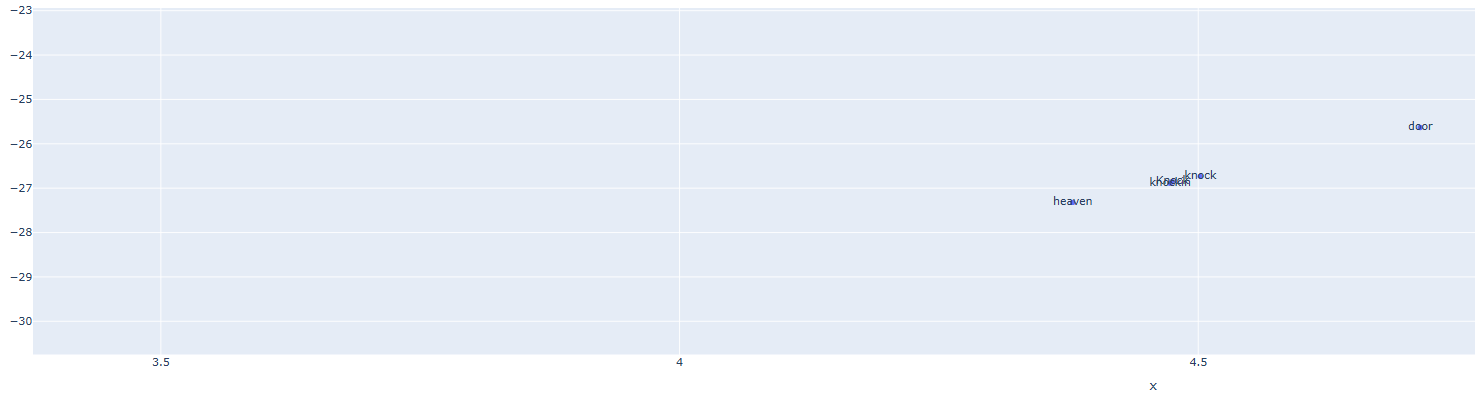

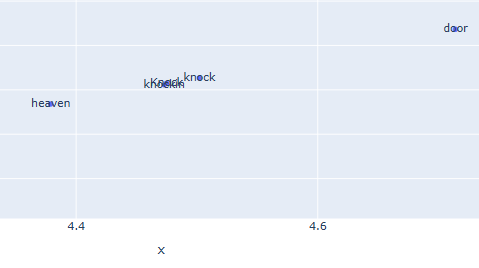

### 4.2) Grupo de palabras nro. 2

Otro grupo de palabras que se encontró se caracteriza por tener los términos `Hey`, `Mr.`, `Tambourine`, `Man`, `play` y `song`. Esto puede deberse a que son términos frecuentes de la canción `Mr. Tambourine man`.

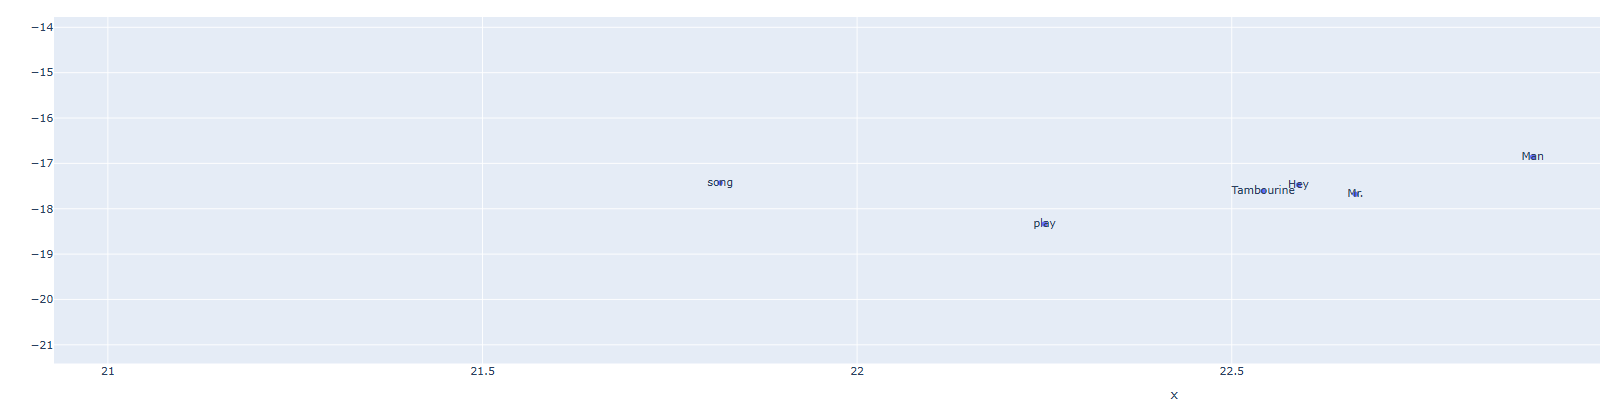

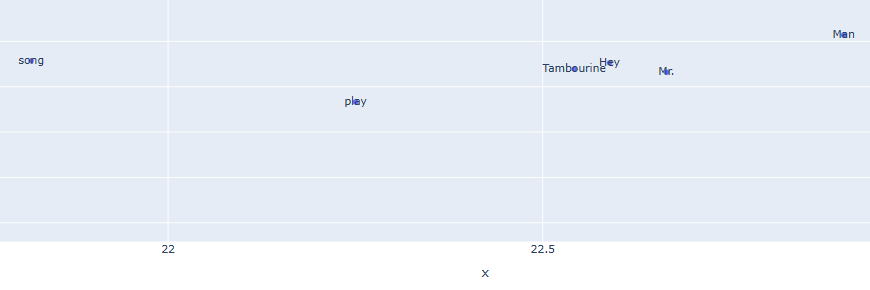

Se muestran además los $10$ términos más similares al término `Tambourine`, en donde se puede observar que `Hey`, `Mr.`, `song` y `Man` aparecen como los *terminos más similares*.

In [124]:
w2v_model.wv.most_similar(positive=["Tambourine"], topn=10)

[('Hey', 0.973122239112854),
 ('Mr.', 0.9524528384208679),
 ('song', 0.8603709936141968),
 ('Man', 0.8475091457366943),
 ('key', 0.8265441656112671),
 ('play', 0.8249216079711914),
 ('chain', 0.7382393479347229),
 ('liked', 0.736402153968811),
 ('animal', 0.7296866774559021),
 ('gave', 0.7117360234260559)]

### 4.3) Grupo de palabras nro. 3

Otro grupo de palabras encontrado tiene los términos de `Come`, `shelter`, `storm` y `give`, los cuales son términos frecuentes de la canción `Shelter from the Storm`.

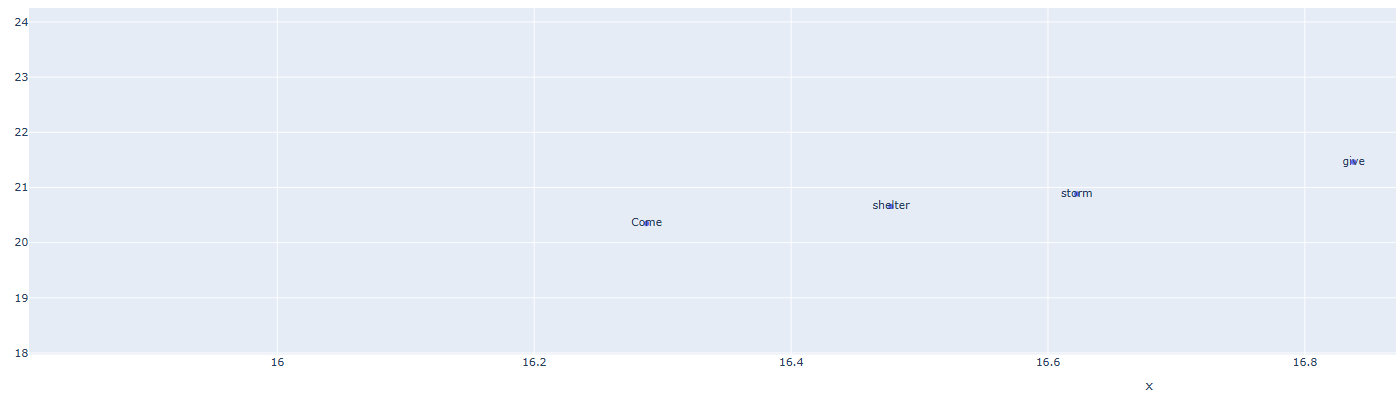

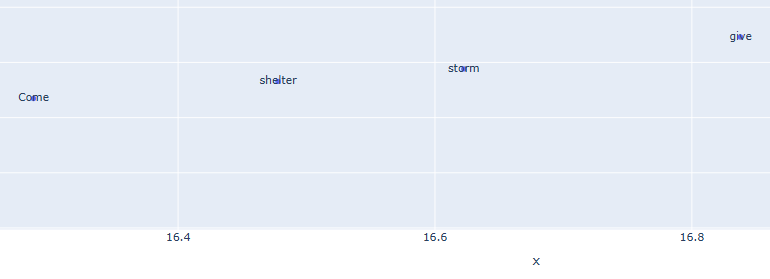

Al buscar los $10$ términos más similares a `shelter`, se nota que `storm` y `Come` son los que mayor similitud tienen ($0.8952$ y $0.8856$ respectivamente), lo cual coincide con el gráfico, ya que son los términos que más próximos están a `shelter`.

Por su parte, `give` aparece como el noveno término con mayor simlitud ($0.6811$).

In [125]:
w2v_model.wv.most_similar(positive=["shelter"], topn=10)

[('storm', 0.8952032923698425),
 ('Come', 0.8856560587882996),
 ('ocean', 0.7693895697593689),
 ('Her', 0.7331797480583191),
 ('younger', 0.7314785718917847),
 ('book', 0.6978211998939514),
 ('mountain', 0.6909820437431335),
 ('Jesus', 0.6905348300933838),
 ('give', 0.6811484098434448),
 ('great', 0.6641724109649658)]

### 4.4) Grupo de palabras nro. 4

Un grupo de palabras interesante es el que contiene los términos `Queen`, `Jane`, `come`, `won`, `alone` y `meet`.

Todos estos términos, a excepción de `alone` y `meet`, aparecen en la canción `Queen Jane Approximately`, de ahí a que se encuentren cerca en la representación de `T-SNE`.

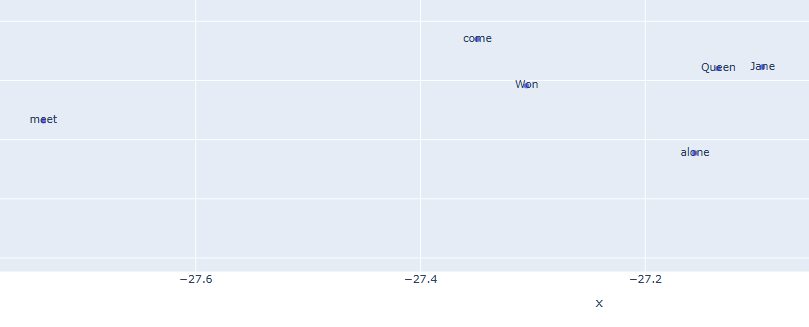

Al analizar los $10$ términos más similares a `meet`, se encuentran los términos `alone` ($0.6234$) y `Jane` ($0.5686$).

Tanto `meet` y `Jane` aparecen en la canción `My blue eyed Jane`. El término `come` también aparece en la canción, pero no en la lista de términos similares de `meet`.

En cuanto a `meet` y `alone`, estos son términos que aparecen frecuentemente en la canción `Moonlight`.

In [132]:
w2v_model.wv.most_similar(positive=["meet"], topn=10)

[('moonlight', 0.847449004650116),
 ('Won', 0.7054582238197327),
 ('blue-eyed', 0.6576330065727234),
 ('darling', 0.6433930993080139),
 ('alone', 0.6251970529556274),
 ('edge', 0.5873676538467407),
 ('valley', 0.5748484134674072),
 ('gather', 0.5691769123077393),
 ('Jane', 0.5686090588569641),
 ('goin', 0.5647902488708496)]

Es decir, en este grupo tenemos términos de tres canciones:

1. `Queen`, `Jane`, `come` y `won` de ***Queen Jane Approximately***.
1. `meet`, `Jane` y `come` de ***My blue eyed Jane***.
1. `meet` y `alone` de ***Moonlight***.

Las canciones $1$ y $2$ se "relacionan" con los términos `Jane` y `come`.

Las canciones $2$ y $3$ se "relacionan" con el término `meet`.

## Conclusiones

Se realizó un análisis sobre un corpus compuesto por las canciones de Bob Dylan.

Dicho corpus fue preprocesado para tokenizar y lematizar los términos, como así también eliminar stop words y signos de puntuación.

Luego, se generó un modelo `Word2Vec`, el cual, una vez entrenado (utilizando $50$ épocas), nos genera ***embeddings*** del corpus.

Una vez obtenidos los embeddings, se graficó una representación en dos dimensiones utilizando ***T-SNE***. En esta representación se observan varios grupos de palabras.

Se estudiaron $4$ grupos en particular, y se encontró que en la mayoría los términos que aparecen son términos frecuentes de alguna canción del corpus. Respecto al cuarto grupo estudiado, se encontró que los términos corresponden a $3$ canciones distintas, las cuales se "relacionan" mediante algún término en común.

En conclusión, podemos decir que los ***embeddings*** son una muy buena técnica para realizar una interpretación semántica de términos de un corpus en una dimensión reducida. Esto lo podemos validar mediante la representación en dos dimensiones hecha con `T-SNE`, en donde se encontraron varios grupos de términos que aparecen en las mismas canciones.